# Knowledge Discovery in Databases I

# Exercise 9: EM, DBSCAN, Mean Shift and Spectral Clustering (Solution) 
## Exercise 9-4: Gaussian Mixture Model, DBSCAN and Spectral Clustering (Solution)

## Gaussian Mixture Model with EM Algorithm

In this exercise, we are in the setting of a Gaussian mixture model, which we want to fit via the EM algorithm. However, we make some restrictions to the usual model.

Assume the following model for your data:
* each point belongs to exactly one cluster $c=1...C$
* for each cluster $c$, the datapoints $x$ are distributed as $x|c\sim N(\mu_c, \sigma I)$, where $\sigma$ does not depend on $c$ and $I$ denotes the identity matrix.
* we assume that all clusters are accounting for the same proportion of the data, i.e. the mixing coefficients are constant, $\pi_1=...=\pi_C$.

That is, the only parameters that we have to estimate are $\mu_c$. In doing so, we will play around with $\sigma$.

### E-step:

Recall
$$
\gamma_j(x_i) = \frac{\pi_j \cdot N(x_i | \mu_j, \Sigma_j)}{\sum_{l=1}^k \pi_l \cdot N(x_i | \mu_l, \Sigma_l)}
$$

What can you say about the responsibilities $\gamma_j(x_i)$ as $\sigma \rightarrow 0$?


Hint: A simple visualization of the values $\gamma_j(x)$ for one-dimensional data $x$ and arbitrary centroids $\mu$ should make it clear. The $\pi_j$ cancels out in our setting.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def compute_responsibilities(x, mus, sig):
    '''
    Computes the responsibilities of the different cluster centers mu for one-dimensional data points x. 
    Assumes that mixing coefficients are constant. 
    '''
    likelihoods = [1./ (sig*np.sqrt(2*np.pi)) * np.exp(-0.5*(x-mu)**2/sig**2) for mu in mus]
    denominator = np.sum(np.array(likelihoods), axis=0)
    return [l/denominator for l in likelihoods]

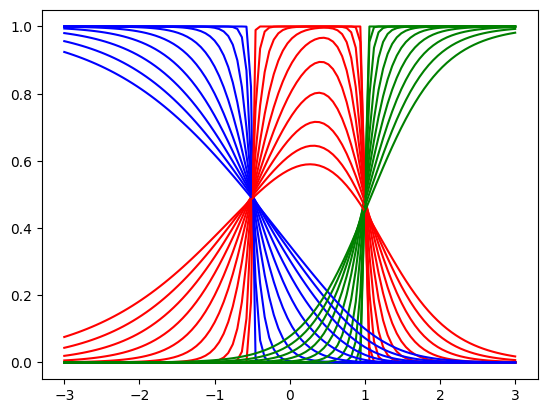

In [2]:
x = np.linspace(-3,3, 100)

for sig in np.linspace(0.1,1,10):
    responsibilities = compute_responsibilities(x,[-1,0,2], sig=sig)
    plt.plot(x, responsibilities[0], c='b')
    plt.plot(x, responsibilities[1], c='r')
    plt.plot(x, responsibilities[2], c='g')
plt.show()

Apparently, for $\sigma \rightarrow 0$, we obtain

$\gamma_j(x) = $
* 1, if $j = argmin_j ||x - \mu_j||_2$
* 0, otherwise

### M-step
How does the M step look under these circumstances?

\begin{align*}
\mu_j &= \frac{\sum_{i=1...N} \gamma_j(x_i) x_i}{\sum_{i=1...N} \gamma_j(x_i)}\\
&= \frac{\sum_{i=1...N \wedge \gamma_j(x_i) = 1} 1 \cdot x_i}{\sum_{i =1...N \wedge \gamma_j(x_i) = 1} 1}\\
&= \frac{\sum_{i=1...N \wedge j = argmin_k ||x_i - \mu_k||_2} x_i}{\#\{i=1...N \wedge j = argmin_k ||x_i - \mu_k||_2\}} \\
&= avg(\{x \in X: j = argmin_k ||x - \mu_k||_2\})
\end{align*}

Doesn't that look familiar? Explain where we arrived at?

Now, the E-step is equivalent to the cluster assignment in k-Means, and the M-step is equivalent to the re-computation of cluster centroids in k-Means. Thus, k-Means can be seen as a special case of EM under Gaussian Mixture Models with several restrictions.

## DBSCAN
Author: Christian Frey

DBSCAN (Density Based Spatial Clustering of Applications with Noise) is designed to discover clusters and noise in a spatial database. It has been published at the KDD'96 and is amongst the density-based clustering algorithms probably the most popular one. 

A naive approach could require for each point in a cluster that there are at least a minimum number $minPts$ of points in an $Eps-neighboorhood$ of that point. This approach fails because there are two kinds of points in a cluster, points inside the cluster (core points) and points on the border of the cluster (border points). Generally, an $Eps$-neighboorhood of a border point contains less points than an $Eps$-neighboorhood of a core point.

> <dl>
    <dt><b>Definition 1</b>: (Eps-neighborhood of a point).</dt> 
    <dd>The Eps-neighborhood of a point p, denoted by $N_{Eps}(p)$ is defined by 
        $$ 
        N_{Eps} \;(p) = \{q \in D | dist(p,q) \leq Eps\} 
        $$
     </dd>
  </dl>

As this value would be hard to set for each point in a cluster and this low value would not be characteristic for a cluster - esp. in the presence of noise - it is required that for every point $p$ in a cluster $C$ there is a point $q \in C$ so that $p$ is inside of the $Eps$-neighboorhood of $q$ and $N_{Eps}(q)$ contains at least $MinPts$ points. This give rise to the following defintion:

> <dl>
    <dt><b>Definition 2</b>: (directly density-reachable). </dt>
    <dd>A point $p$ is directly density-reachable from a point $q$ w.r.t $eps$, minPts if two conditions hold:
         $p \in N_{Eps}(q)$
         and 
         $|N_{Eps}(q)| \geq MinPts$ (core point condition)
    </dd>
  </dl>

Directly density-reachable is symmetric for pairs of core points. In general, however, it is not symmetric if one core point and one border point are involved. 

> <dl>
    <dt><b>Definition 3</b>: (density-reachable).</dt>
    <dd>A point $p$ is density-reachable from a point $q$ w.r.t $Eps$ and $MinPts$ if there is a chain of point $p_1, \ldots, p_n$, $p_1 = q$, $p_n = p$ such that $p_{i+1}$ is directly density-reachable from $p_i$.
    </dd>
  </dl>

Density-reachability is a canonical extension of direct density-reachability. This relation is transitive, but it is not symmetric. 

Two border points of the same cluster $C$ are possibly not density reachable from each other because the core point condition might not hold for both of them. However, there must be a core point in $C$ from which both border points of $C$ are density-reachable. Therefore, the authors introduced the notion of density-connectivity covering the relation of border points.

> <dl>
    <dt><b>Defintion 4</b>: (density-connected).</dt>
    <dd>A point $p$ is density-connected to a point $q$ w.r.t $Eps$ and $MinPts$ if there is a point $o$ such that both, $p$ and $q$ are density-reachable from $o$ w.r.t $Eps$ and $MinPts$.
    </dd>
  </dl>

Hence, the density-connectivity is a symmetric relation. 

The pseudocode of the original sequential DBSCAN Algorithm is given by:

```python
Input: DB, ε, minPts, dist_fnc, labels
1 foreach point p in database DB do
2     if label(p) != undefined then continue
3     Neighbors N ← RangeQuery(DB,dist,p,ε)
4     if |N| < minPts then
5         label(p) ← Noise
6         continue
7     c ← next cluster label
8     label(p) ← c
9     Seed set S ← N \ {p}
10    foreach q in S do
11        if label(q) = Noise then label(q) ← c
12        if label(q) != undefined then continue
13        Neighbors N ← RangeQuery(DB, dist, q, ε)
14        label(q)←c
15        if |N| < minPts then continue
16        S←S u N
```

Implement the DBSCAN algorithm.

Hint: You do not have to care about efficient range queries etc.

In [3]:
import scipy as scipy
import matplotlib.pyplot as plt
import numpy as np

class DBSCAN(object):
    '''
    This class implements the density based spatial clustering in applications with noise algorithm
    
    Arguments:
      eps: epsilon being used to identify the eps-neighborhood of a datapoint
      min_pts: minimal number of points s.t. a datapoint can be considered as a core object if the number
        of points in the eps-neighborhood exceeds min_pts
      dist_method: distance function being used to calculate the proximity of two datapoints
      
    Properties:
      eps: epsilon value for the eps-neighborhood
      min_pts: minimal number of points for identifying core objects
      dist_method: distance fnc
      labels: labels of the datapoints, i.e., the affiliation of the points to the clusters
    '''
    
    def __init__(self, eps, min_pts, dist_method='euclidean'):
        self.eps=eps
        self.min_pts=min_pts
        self.dist_method=dist_method
        self.labels = None
        self.D = None # distance matrix for range queries

        
    def fit(self, data):
        '''
        This method executes the DBSCAN algorithm on the attached 
        dataset. First, it calculates the distances for each point
        within the dataset to each other point. By iterating the whole
        dataset, we can identify the affiliation for the points to 
        clusters. Hence, if we have found a core point, the point
        is used to expand the cluster, i.e., by calling the subroutine
        _expand_cluster(.), we can identfy each point being density
        reachable from a core point. If for a datapoint the conditions
        for a core point do not hold, we can regard this point as a 
        noise point (maybe border point). After the cluster expansion,
        we take the next unlabeled point and continue in the same manner
        as described till every point is labeled. 
        
        Arguments:
          data: the dataset
        '''
        # initialize distance matrix
        self.D = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(data, self.dist_method))
        n = len(data)
        self.labels = -np.ones(n) # -1:unvisited, 0:noise, k:cluster k
        current_label = 0
        
        for p in range(n):
            if self.labels[p]!= -1:
                continue
            
            N = self._range_query(p)
            
            if len(N) < self.min_pts:
                self.labels[p] = 0 # noise
                continue
            
            current_label += 1
            self.labels[p] = current_label
            self._expand_cluster(p, N, current_label)
            
    def _expand_cluster(self, p, N, current_label):
        '''
        This method is used to aggregate all points being density
        reachable by the datapoint being attached as parameter ('point').
        All point which have been marked to be NOISE may be changed, if 
        they are density-reachable from some other point within the cluster.
        This happens for border points of a cluster. 
        
        Arguments:
          point: the datapoint from which on we expand the cluster
          seed_set: a set containing all points being density reachable
            within the cluster being currently regarded
          cluster_idx: the id of the current cluster
          dist_mx: a distance matrix NxN containing the proximity for 
            each point in the dataset to each other point 
        '''
        for q in N:
            if self.labels[q] == 0:
                self.labels[q] = current_label
            if self.labels[q] != -1:
                continue
            self.labels[q] = current_label
            N_q = self._range_query(q)
            if len(N_q) > self.min_pts:
                self._expand_cluster(q, N_q, current_label)
                
    def _range_query(self, p):
        '''
        Return the indices of point in eps-range of the point at index p (not including the point itself). 
        '''
        N = np.where(self.D[p,:] < self.eps)[0] # eps-neighborhood
        N = N[N != p]  # exclude p from neighbors
        return N

Test your implementation:

In [4]:
from sklearn.datasets import make_blobs
X, y_true = make_blobs(n_samples=300, centers=4, cluster_std=0.60, random_state=0)

In [5]:
dbscan = DBSCAN(0.5, 5)
dbscan.fit(X)

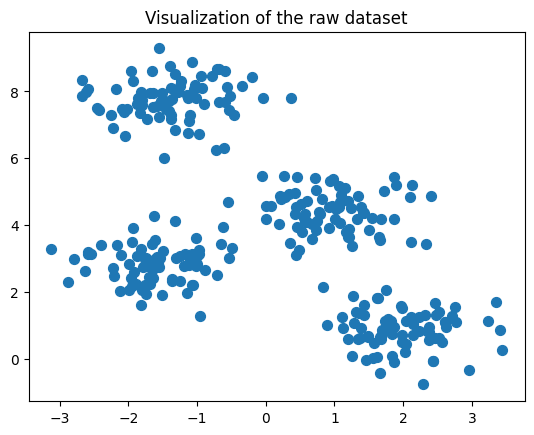

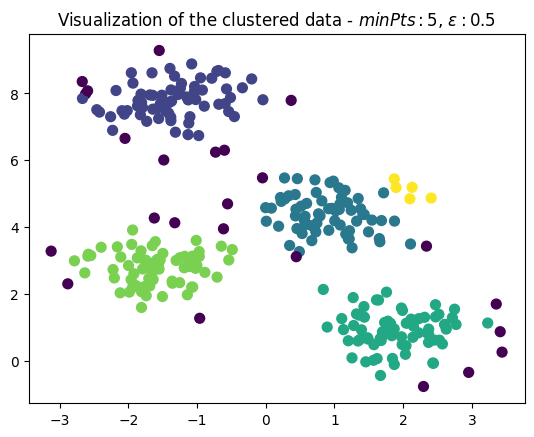

In [6]:
plt.scatter(X[:, 0], X[:, 1], s=50)
plt.title("Visualization of the raw dataset")
plt.show()

plt.scatter(X[:, 0], X[:, 1], c=dbscan.labels, s=50,  cmap='viridis')
plt.title("Visualization of the clustered data - $minPts:{minPts}$, $\epsilon:{eps}$".format(minPts=dbscan.min_pts, eps=dbscan.eps))
plt.show()

#### Additional notes
* published in: Ester M., Kriegel H.P., Sander J., Xu X., A Density-Based Algorithm for Discovering Clusters in Large Spatial Databases with Noise", in KDD 1996, pp. 226-331 

## DBSCAN Determinacy

Does DBSCAN always result in the same clustering for the same dataset? Justify your answer with an explanation or a counterexample.

We provide a counterexample.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

In [8]:
X1 = np.array([0,1,2,3,5,7,8,9,10]).reshape(-1,1)
X2 = np.flip(X1, axis=0)

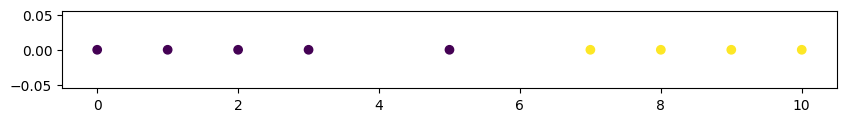

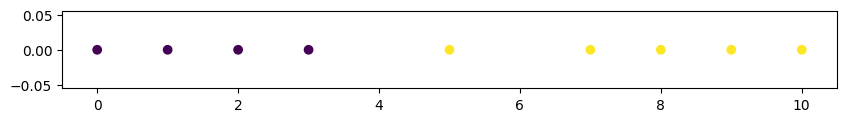

In [9]:
dbscan1 = DBSCAN(eps=2, min_samples=4)
labels1 = dbscan1.fit_predict(X1)
dbscan2 = DBSCAN(eps=2, min_samples=4)
labels2 = dbscan2.fit_predict(X2)

plt.figure(figsize=(10,1))
plt.scatter(X1[:,0], np.zeros(len(X1)), c=labels1)
plt.show()
plt.figure(figsize=(10,1))
plt.scatter(X2[:,0], np.zeros(len(X2)), c=1-labels2)
plt.show()

As we can see, DBSCAN is only deterministic up to the order of the data and the border points. That is, if a border point is density reachable from two clusters (5 in our example), then the label of that point will depend on which cluster is created and expanded first. Apart from that, core points and noise points are independent of the processing order.

## Spectral Clustering
Implement the spectral clustering algorithm. The number of clusters should be specified beforehand. The data points should be passed as a 2d-array. 

The graph used to determine the clustering should be created from the datapoints based on the kNN-graph (`sklearn.neighbors.kneighbors_graph`). 
Using the exact kNN-graph does not work. Why? What is a reasonable way to circumvent that?

In [10]:
import numpy as np
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import KMeans

class SpectralClustering:
    def __init__(self, n_clusters, n_components=None, n_neighbors=5):
        self.n_clusters = n_clusters # number of clusters for k-means
        self.n_components = n_components if n_components is not None else n_clusters # number of eigvecs to use
        self.n_neighbors = n_neighbors # number of neighbors for kNN-graph
        
    def fit(self, X):
        L = self.get_graph_laplacian(X)
        eig_values, eig_vectors = np.linalg.eig(L)
        order = np.argsort(eig_values)
        U = eig_vectors[:,order[:self.n_components]]
        kmeans = KMeans(self.n_clusters)
        self.labels = kmeans.fit_predict(U)
    
    def get_graph_laplacian(self, X):
        A = kneighbors_graph(X,n_neighbors=self.n_neighbors).toarray()
        A = np.maximum(A, A.T) # make symmetric
        D = np.diag(np.sum(A, axis=1))
        return D - A

Test your implementation on the following dataset.

In [11]:
from sklearn.datasets import make_blobs
X, y_true = make_blobs(n_samples=300, centers=4, cluster_std=0.60, random_state=0)

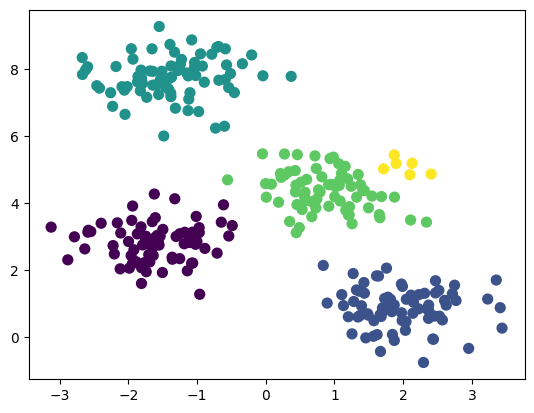

In [12]:
import matplotlib.pyplot as plt
sc = SpectralClustering(n_clusters=5,n_neighbors=5)
sc.fit(X)
plt.scatter(X[:, 0], X[:, 1], c=sc.labels, s=50,  cmap='viridis')
plt.show()